# Identify generic genes and pathways

Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These generic genes and subsequent pathways are not necessarily specific to the biological process being studied but instead represent a more systematic change.

This notebook identifies generic genes and pathways and then evaluates if those identified are consistent with published findings.

**Steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

  In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.


3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic (i.e. log fold change, or p-value)


**Steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

**Evaluation:**
* We want to compare the ranking of genes identified using the above method with the ranking found from [Crow et. al.](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), which identified a set of genes as generic based on how frequently they were found to be DE across 600 experiments
* We want to compare the ranking of pathways identified using the above method with the ranking based on the [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) data, where ranking was determined based on the fraction of 442 experiments a pathway was found to be enriched
* This comparison will validate our method being used as a way to automatically identify generic genes and pathways.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import pickle

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import process, stats, ranking

np.random.seed(123)

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
mapped_template_filename = params['mapped_template_filename']
processed_template_filename = params['processed_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']
col_to_rank_genes = params['rank_genes_by']
col_to_rank_pathways = params['rank_pathways_by']
statistic = params['gsea_statistic']
count_threshold = params['count_threshold']

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_groups.tsv"
)

# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

In [4]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}.tsv"
)

pathway_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_pathway_summary_{project_id}.tsv"
)

### Simulate experiments using selected template experiment

Workflow:

1. Get the gene expression data for the selected template experiment
2. Encode this experiment into a latent space using the trained VAE model
3. Linearly shift the encoded template experiment in the latent space
4. Decode the samples. This results in a new experiment
5. Repeat steps 1-4 to get multiple simulated experiments

In [5]:
# Simulate multiple experiments
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:           
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1] 
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)
for run_id in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_filename,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run_id
    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## Process template and simulated experiments

* Remove samples not required for comparison
* Make sure ordering of samples matches metadata for proper comparison
* Make sure values are cast as integers for using DESeq
* Filter lowly expressed genes for using DESeq

In [6]:
if not os.path.exists(sample_id_metadata_filename):
    sample_id_metadata_filename = None
    
stats.process_samples_for_DESeq(
        mapped_template_filename,
        metadata_filename,
        processed_template_filename,
        count_threshold,
        sample_id_metadata_filename,
    )

for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt"
    )
    out_simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}_processed.txt"
    )
    stats.process_samples_for_DESeq(
        simulated_filename,
        metadata_filename,
        out_simulated_filename,
        count_threshold,
        sample_id_metadata_filename,
)

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


### Differential expression analysis

The gene expression dataset is using RNA-seq so we will use DESeq2 in this case

In [7]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [8]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   project_id, 
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE


In [9]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats['padj']<0.01) & (abs(template_DE_stats['log2FoldChange'])>1)]
print(selected.shape)

(3277, 6)


In [10]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_SRP012656_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir, 
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_", 
                                     i,
                                     "_processed.txt",
                                     sep = "")
    
    get_DE_stats_DESeq(metadata_filename,
                       project_id, 
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: -- replacing outliers and refitting for 89 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: -- replacing outliers and refitting for 13 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: -- replacing outliers and refitting for 36 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/sit

[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checki

**Validation:**
* As a quick validation, [Kim et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/) found 1459 DEGs (543 upregulated and 916 downregulated) using used the Bowtie and NEUMA applications for the mapping and quantification of RNA-Seq data. They used *edgeR* with a rigorous filtering procedure based on false discovery rates, minimum applicable patient numbers, and gene expression levels was devised to select reliable sets of DEGs and DEIs (see File S8 for details). For the

* Our results found ~3K DEGs which is close enough in range given that the data was processed using different methods. recount2 resource were aligned with the splice-aware Rail-RNA aligner

### Rank genes

In [11]:
analysis_type = "DE"
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
)

### Gene summary table

Note: Using DESeq, genes with NaN in `Adj P-value (Real)` column are those genes flagged because of the `cooksCutoff` parameter. The cook's distance as a diagnostic to tell if a single sample has a count which has a disproportionate impact on the log fold change and p-values. These genes are flagged with an NA in the pvalue and padj columns of the result table. For more information you can read [DESeq FAQs](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA)

In [12]:
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    'gene',
    params
)

summary_gene_ranks.head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.950002e-13,17569.0,10.694069,10.694069,0.002644,15703.0,2.071917,1.709101,22,5.044847
PRAME,PRAME,2.959850e-15,17568.0,8.664896,8.664896,0.020151,13854.0,2.219810,2.247802,22,2.867283
SLCO1B3,SLCO1B3,5.291828e-04,17567.0,8.325529,8.325529,0.000205,16755.0,2.723600,1.671151,22,3.352139
KCNC2,KCNC2,1.983864e-10,17566.0,8.230783,8.230783,0.078105,15568.0,2.091518,1.844180,22,3.328995
HOTAIR,HOTAIR,3.115155e-10,17565.0,8.228355,8.228355,0.000887,17311.0,3.252611,2.453541,20,2.027985


In [13]:
summary_gene_ranks.isna().any()

Gene ID                                 False
Adj P-value (Real)                       True
Rank (Real)                              True
abs(log2FoldChange) (Real)               True
log2FoldChange (Real)                    True
Median adj p-value (simulated)          False
Rank (simulated)                        False
Mean abs(log2FoldChange) (simulated)    False
Std deviation (simulated)               False
Number of experiments (simulated)       False
Z score                                  True
dtype: bool

In [14]:
# Create `gene_summary_filename`
summary_gene_ranks.to_csv(gene_summary_filename, sep='\t')

### Compare gene ranking
Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represent a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

r = 0.1851597404594152
p = 3.711325673092676e-132
ci_low = 0.17014955888776914
ci_high = 0.19862886522764006


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


{'r': 0.1851597404594152,
 'p': 3.711325673092676e-132,
 'ci_low': 0.17014955888776914,
 'ci_high': 0.19862886522764006}

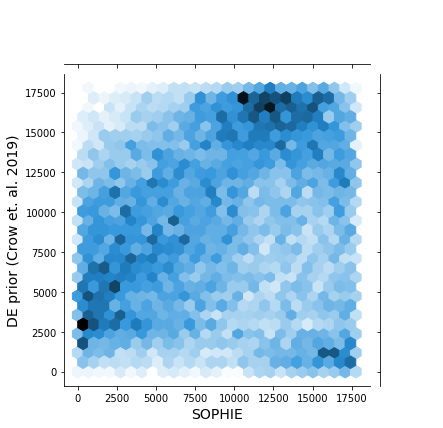

In [15]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params['reference_gene_filename']
ref_gene_col = params['reference_gene_name_col']
ref_rank_col = params['reference_rank_col']

figure_filename = f"gene_ranking_{col_to_rank_genes}.svg"

ranking.compare_gene_ranking(
    summary_gene_ranks,
    DE_prior_filename,
    ref_gene_col,
    ref_rank_col,
    figure_filename
)

**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.

### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Rank all genes using DE association statistics.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES (i.e. scores based on permuted phenotype)

In [16]:
# Create "<local_dir>/GSEA_stats/" subdirectory
os.makedirs(os.path.join(local_dir, "GSA_stats"), exist_ok=True)

In [17]:
# Load pathway data
hallmark_DB_filename = params["pathway_DB_filename"]

In [18]:
%%R -i base_dir -i template_DE_stats_filename -i hallmark_DB_filename -i statistic -o template_enriched_pathways

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

out_filename <- paste(local_dir, 
                     "GSA_stats/GSEA_stats_template_data_",
                     project_id,
                     "_real.txt", 
                     sep = "")

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_filename, hallmark_DB_filename, statistic)

write.table(as.data.frame(template_enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [19]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways['padj'] < 0.05].sort_values(by='padj')

(50, 8)


,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
12,HALLMARK_E2F_TARGETS,0.000123,0.002057,0.545914,1.925797,0.0,185,None
17,HALLMARK_G2M_CHECKPOINT,0.000123,0.002057,0.544701,1.919914,0.0,184,None
18,HALLMARK_GLYCOLYSIS,0.000122,0.002057,0.519166,1.842837,0.0,196,None
22,HALLMARK_IL2_STAT5_SIGNALING,0.000551,0.003112,-0.433876,-1.788689,0.0,193,None
6,HALLMARK_APOPTOSIS,0.000485,0.003112,-0.415512,-1.674607,0.0,156,None
44,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000560,0.003112,-0.672292,-2.774243,0.0,197,None
33,HALLMARK_MYOGENESIS,0.000553,0.003112,-0.438242,-1.809346,0.0,195,None
23,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.000364,0.003112,-0.489186,-1.802326,0.0,85,None
24,HALLMARK_INFLAMMATORY_RESPONSE,0.000560,0.003112,-0.522549,-2.156324,0.0,197,None
43,HALLMARK_TGF_BETA_SIGNALING,0.000632,0.003160,-0.592356,-2.008769,1.0,54,None


In [20]:
%%R -i project_id -i local_dir -i hallmark_DB_filename -i num_runs -i statistic -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

# New files created: "<local_dir>/GSEA_stats/GSEA_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)) {
    simulated_DE_stats_filename <- paste(local_dir, 
                                     "DE_stats/DE_stats_simulated_data_", 
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    out_filename <- paste(local_dir, 
                     "GSA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep = "")
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_filename, hallmark_DB_filename, statistic) 
    
    write.table(as.data.frame(enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")
}

### Rank pathways 

In [21]:
analysis_type = "GSA"
template_GSEA_stats_filename = os.path.join(
    local_dir,
    "GSA_stats",
    f"GSEA_stats_template_data_{project_id}_real.txt"    
)
template_GSEA_stats, simulated_GSEA_summary_stats = ranking.process_and_rank_genes_pathways(
    template_GSEA_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_pathways,
    "GSEA"
)

### Pathway summary table

In [22]:
# Create intermediate file: "<local_dir>/gene_summary_table_<col_to_rank_pathways>.tsv"
summary_pathway_ranks = ranking.generate_summary_table(
    template_GSEA_stats_filename,
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    col_to_rank_pathways,
    local_dir,
    'pathway',
    params
)

summary_pathway_ranks.head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Pathway ID,Adj P-value (Real),Rank (Real),padj (Real),Median adj p-value (simulated),Rank (simulated),Mean padj (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,0.002057,49.0,0.002057,0.804506,24.0,0.598456,0.443755,22,-1.343982
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,0.002057,49.0,0.002057,1.000000,6.5,0.671206,0.429360,19,-1.558479
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,0.002057,49.0,0.002057,1.000000,6.5,0.635813,0.438649,17,-1.444790
HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,0.003112,44.5,0.003112,0.295688,40.0,0.432404,0.435609,25,-0.985499
HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_IL2_STAT5_SIGNALING,0.003112,44.5,0.003112,1.000000,6.5,0.646606,0.428842,25,-1.500536


In [23]:
# Create `pathway_summary_filename`
summary_pathway_ranks.to_csv(pathway_summary_filename, sep='\t')

### Compare pathway ranking

Studies have found that there are some pathways (gene sets) that are more likely to be significantly enriched in DEGs across a wide range of experimental designs. These generic pathways are not necessarily specific to the biological process being studied but instead represents a more systematic change.

We want to compare the ability to detect these generic pathways using our method vs those found by [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) publication.  We will use the `Hallmarks_qvalues_GSEAPreranked.csv` file from https://www.synapse.org/#!Synapse:syn11806255 as a reference. The file contains the q-value (adjusted p-value) for the test: given the enrichment score (ES) of the experiment is significant compared to the null distribution of enrichment scores, where the null set is generated from permuted gene sets. For each gene set (pathway) they calculate the q-value using this test. 


To get a `reference ranking`, we calculate the fraction of experiments that a given pathway was significant (q-value <0.05) and use this rank pathways. `Our ranking` is to rank pathways based on the median q-value across the simulated experiments. We can then compare `our ranking` versus the `reference ranking.`

In [24]:
# Load Powers et. al. results file
powers_rank_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked.csv"
)

In [25]:
# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_filename, header=0, index_col=0)
powers_rank_df.drop(['Category'], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()

(50, 443)


,GSE10281_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group2_qval,GSE10311_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group2_qval,GSE10592_DEG_Expt1_Control_vs_Group1_qval,GSE10592_DEG_Expt2_Control_vs_Group1_qval,GSE11142_DEG_Expt1_Control_vs_Group1_qval,GSE11285_DEG_Expt1_Control_vs_Group1_qval,...,GSE79761_DEG_Expt1_Control_vs_Group2_qval,GSE79761_DEG_Expt1_Control_vs_Group3_qval,GSE83120_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt2_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group2_qval,GSE8597_DEG_Expt1_Control_vs_Group1_qval,GSE8658_DEG_Expt1_Control_vs_Group1_qval,GSE9988_DEG_Expt1_Control_vs_Group1_qval
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_APICAL_JUNCTION,0.010497,0.994108,0.045536,0.498151,0.538082,0.429205,0.355439,0.236627,0.767614,0.858065,...,0.637333,0.019621,0.086923,0.453315,0.730539,0.005366,0.863592,0.102867,0.639821,0.465678
HALLMARK_APICAL_SURFACE,0.443835,0.598008,0.181818,0.407927,0.130422,0.588732,0.192183,0.003519,1.000000,0.809823,...,0.260565,0.018686,0.691567,0.588169,1.000000,0.172392,0.657082,0.008060,0.618102,0.229456
HALLMARK_PEROXISOME,0.110897,0.988705,0.118807,0.094770,0.004288,0.115514,0.172297,0.035202,0.682219,0.393990,...,0.447485,0.380294,0.058549,0.110354,0.215365,0.006037,0.034110,0.331770,0.005224,1.000000
HALLMARK_ADIPOGENESIS,0.011177,0.461255,0.171288,0.020412,0.010720,0.000000,0.191663,0.846586,0.895637,0.056589,...,0.604963,0.805532,0.054415,0.022888,0.000000,0.735339,0.636778,0.649874,0.000000,0.435622
HALLMARK_ANGIOGENESIS,0.006014,0.380219,0.663985,0.992954,0.175682,0.010256,0.004750,0.015640,1.000000,0.402218,...,0.007489,0.023545,0.965871,0.035213,0.646400,0.004025,0.209530,0.007165,0.181685,0.108067


In [26]:
# Count the number of experiments where a given pathway was found to be enriched (qvalue < 0.05)
total_num_experiments = powers_rank_df.shape[1]
frac_enriched_pathways = ((powers_rank_df < 0.05).sum(axis=1) / total_num_experiments)

# Rank pathways from 0-50, 50 indicating that the pathways was frequently enriched
pathway_ranks = frac_enriched_pathways.rank()

powers_rank_stats_df = pd.DataFrame(
    data={
        'Fraction enriched': frac_enriched_pathways.values,
        'Powers Rank':pathway_ranks.values
    },
    index=powers_rank_df.index
)
powers_rank_stats_df.head()

,Fraction enriched,Powers Rank
Term,,
HALLMARK_APICAL_JUNCTION,0.124153,4.0
HALLMARK_APICAL_SURFACE,0.128668,5.5
HALLMARK_PEROXISOME,0.148984,7.5
HALLMARK_ADIPOGENESIS,0.182844,15.0
HALLMARK_ANGIOGENESIS,0.191874,16.5


In [27]:
# Save reference file for input into comparison
powers_rank_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked_processed.tsv"
)

powers_rank_stats_df.to_csv(powers_rank_processed_filename, sep="\t", )

r = -0.35185812737679295
p = 0.012218097986679539
ci_low = -0.5782330832148761
ci_high = -0.07560256844428462


{'r': -0.35185812737679295,
 'p': 0.012218097986679539,
 'ci_low': -0.5782330832148761,
 'ci_high': -0.07560256844428462}

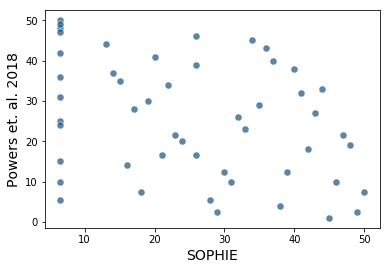

In [28]:
figure_filename = f"pathway_ranking_{col_to_rank_pathways}.svg"

ranking.compare_pathway_ranking(
    summary_pathway_ranks,
    powers_rank_processed_filename,
    figure_filename
)

**Takeaway:**

* The above shows that there is no correlation between our ranking (where pathways were ranked using median adjusted p-value score across simulated experiments) vs Powers et. al. ranking (where pathways were ranked based on the fraction of experiments they had adjusted p-value < 0.05). This is using the same workflow used to compare ranking of genes. 

* We validated that our analysis pipeline is working correctly by comparing pathway ranks obtained from a (Powers et. al.)-trained VAE model vs pathway ranking based on manual curation using Powers et. al datasets. We expect to see a high correlation between pathway ranks given that we are using the same training dataset. Indeed that is what we find [here](../human_cancer_analysis/2_identify_generic_genes_pathways.ipynb).

**Therefore,** 

* We find relatively similar generic genes using our simulation approach (i.e. VAE model trained on a cancer-specific dataset, Powers et. al.) compared to generic genes found from real general experiments from Crow et. al. These generic genes are not that context-specific at the extremes.

* We found very different generic pathways training using our simulation approach trained on a general dataset (recount2) compared to generic pathways found from real cancer-specific experiments from Powers et. al. See [analysis](../human_cancer_analysis/2_identify_generic_genes_pathways.ipynb). But we get very similar generic pathways using our simulation approach trained on a cancer-specific dataset (Powers et. al.) compared with generic pathways found from cancer-specific dataset (Powers et. al.). This indicates that generic pathways are more context specific. 

* Why would the context matter more for pathways as opposed to genes? One way to think about this is using this figure from a recent [preprint](https://www.biorxiv.org/content/10.1101/2020.07.30.228296v1).Information flows from a stimulation that activates proteins within pathways and these proteins regulate gene expression. Say we have a context specific signal, that changes the TF within some pathways, this eventually trickles down to changes in gene expression. So if we think about flow of information, measuring pathway activity (or pathway enrichment, etc) will be more sensitive to our context compared to measuring DE in individual genes. Since the genes are regulated as a group, you'd see coordinated changes in expression that are correlated with your condition but looking at the expression of individual genes you wouldn’t necessarily see this correlation with condition.